In [ ]:
!pip install yfinance prophet --quiet
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')


In [ ]:
data = yf.download("^NSEI", start="2015-01-01", end="2024-12-31")
data = data[['Close']]
data.dropna(inplace=True)
data.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,^NSEI
Date,
2024-12-23,23753.449219
2024-12-24,23727.650391
2024-12-26,23750.199219
2024-12-27,23813.400391
2024-12-30,23644.900391


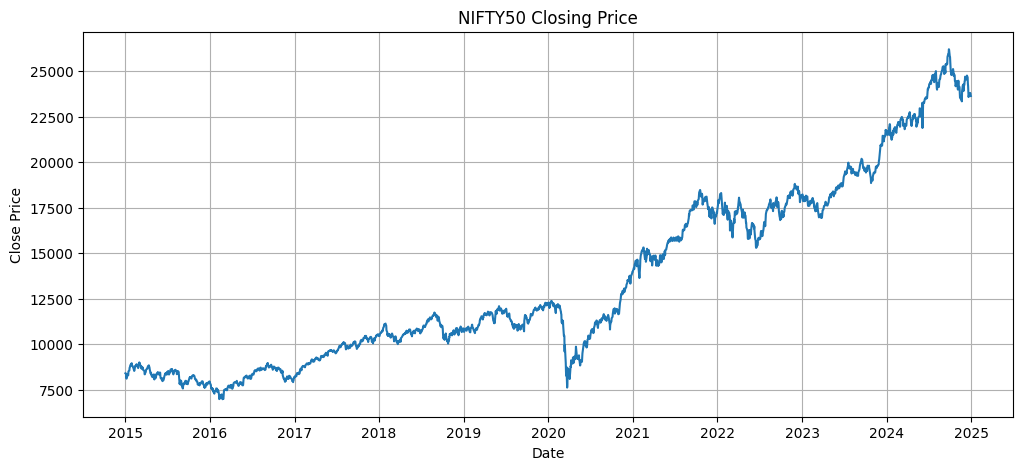

ADF Statistic: 0.4721358953136749
p-value: 0.9840011257018442


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data['Close'])
plt.title('NIFTY50 Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.show()

adf_result = adfuller(data['Close'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


In [ ]:
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_RSI(data['Close'])


DEBUG:cmdstanpy:input tempfile: /tmp/tmpu1jt6hys/7niax_g_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu1jt6hys/l9m_eck7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42298', 'data', 'file=/tmp/tmpu1jt6hys/7niax_g_.json', 'init=/tmp/tmpu1jt6hys/l9m_eck7.json', 'output', 'file=/tmp/tmpu1jt6hys/prophet_modelqj5oti_5/prophet_model-20250716162352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


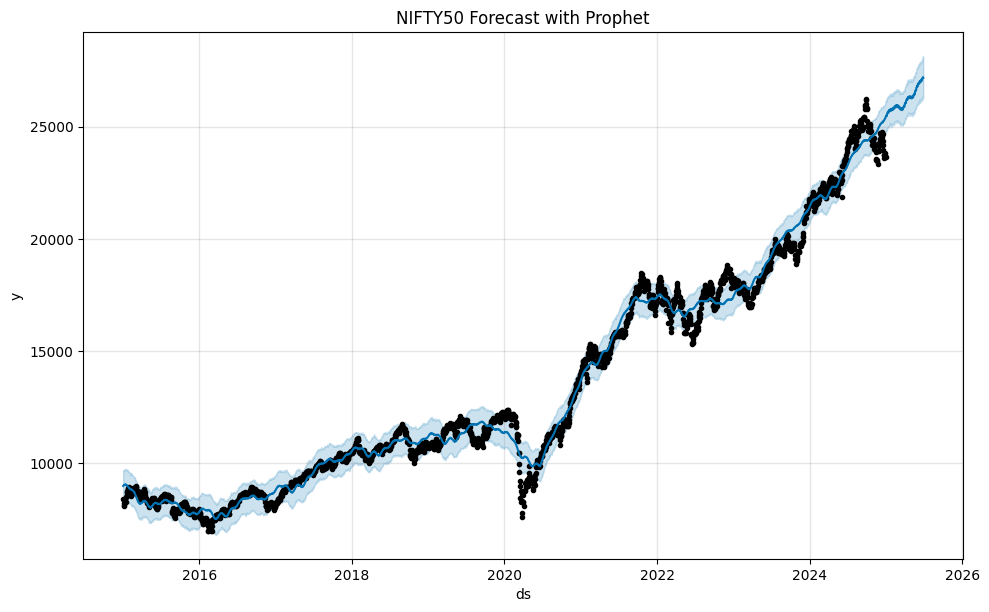

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0167
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 3.5115e-04
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 3.2801e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.2491e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.4420e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 2.8635e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 2.4698e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.5526e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.1537e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 2.0913e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


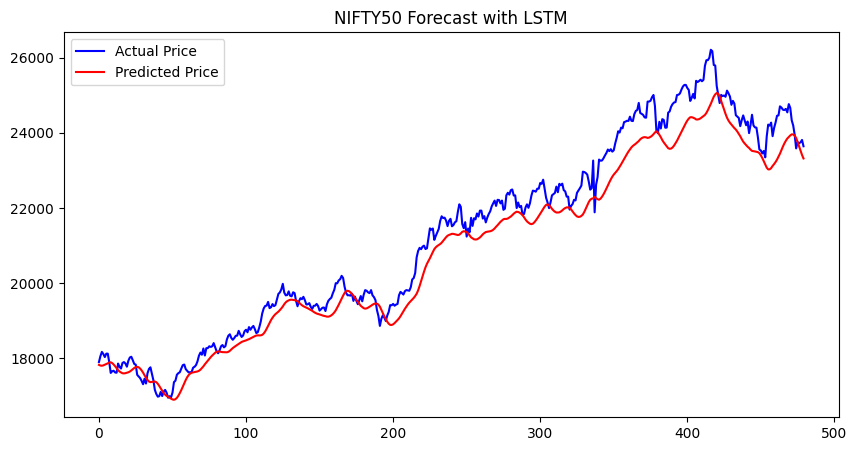

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close']])

sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

predicted = model_lstm.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)

real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(real, color='blue', label='Actual Price')
plt.plot(predicted_prices, color='red', label='Predicted Price')
plt.title('NIFTY50 Forecast with LSTM')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(real, predicted_prices))
mae = mean_absolute_error(real, predicted_prices)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 573.0819687425217
MAE: 473.8842407226561


In [ ]:
import pandas as pd
import yfinance as yf

# Download NIFTY50 data
data = yf.download("^NSEI", start="2015-01-01", end="2024-12-31")
data = data[['Close']].dropna()

# Feature Engineering: SMA and RSI
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

def compute_RSI(series, window=14):
    diff = series.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_RSI(data['Close'])

data_cleaned = data.dropna()

data_cleaned.to_excel("NIFTY50_Cleaned_Data.xlsx")
print("✅ Excel file saved as NIFTY50_Cleaned_Data.xlsx")


[*********************100%***********************]  1 of 1 completed


✅ Excel file saved as NIFTY50_Cleaned_Data.xlsx


In [ ]:
from google.colab import files
files.download("NIFTY50_Cleaned_Data.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install streamlit yfinance prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.2 MB/s eta 0:00:00


2025-07-16 16:29:03.914 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 16:29:03.919 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 16:29:04.430 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-16 16:29:04.431 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 16:29:04.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 16:29:04.433 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 16:29:04.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

DeltaGenerator()

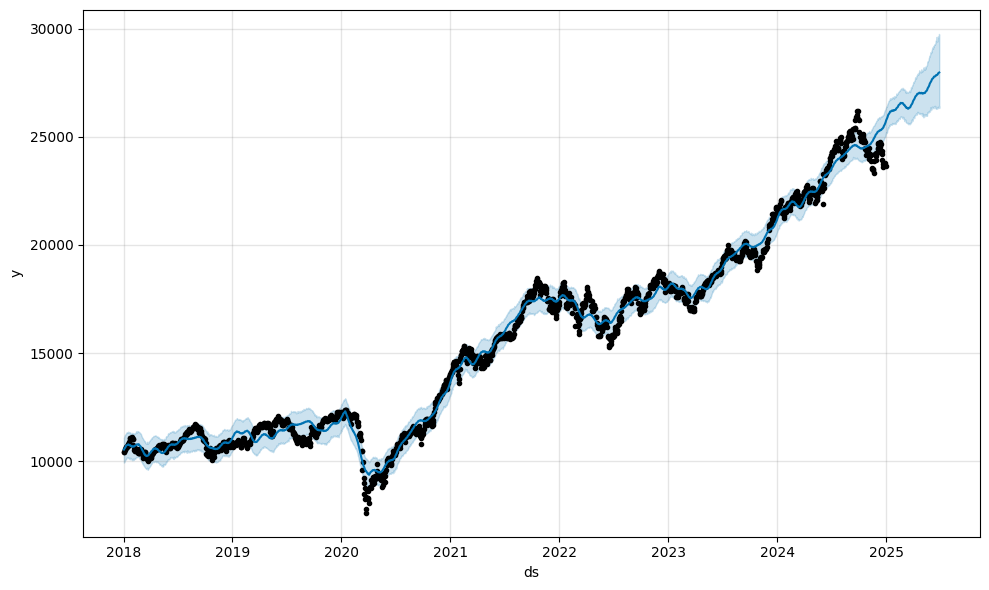

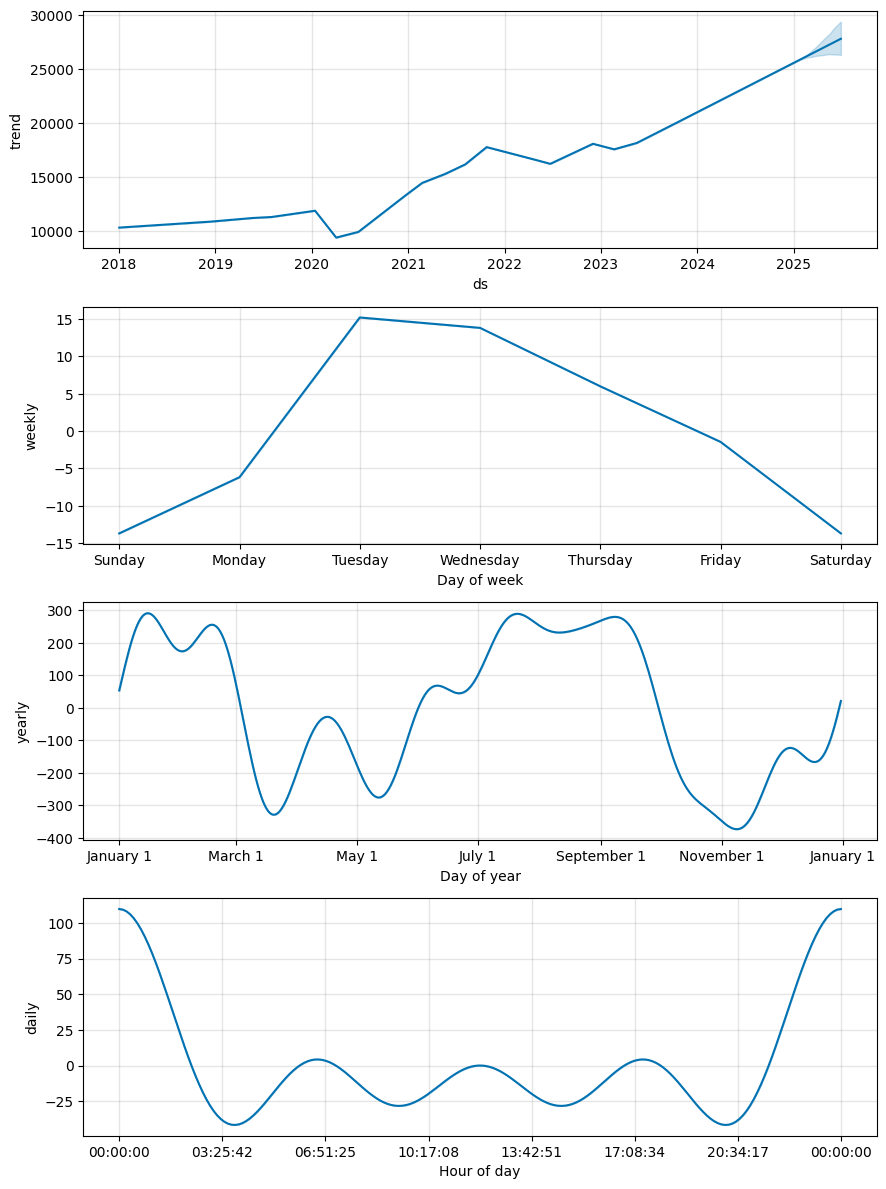

In [ ]:
import streamlit as st
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt

st.set_page_config(layout="wide")

st.title("📈 NIFTY50 Demand Forecast Dashboard")

st.sidebar.header("User Input")
start_date = st.sidebar.date_input("Start Date", pd.to_datetime("2018-01-01"))
end_date = st.sidebar.date_input("End Date", pd.to_datetime("2024-12-31"))

@st.cache_data
def load_data():
    data = yf.download("^NSEI", start=start_date, end=end_date)
    data.reset_index(inplace=True)
    return data

data_load_state = st.text("Loading data...")
df = load_data()
data_load_state.text("✅ Data loaded!")

if st.checkbox("Show raw data"):
    st.write(df.tail())

df_prophet = df[["Date", "Close"]]
df_prophet.columns = ['ds', 'y']

model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

st.subheader("📉 Forecast Plot")
fig1 = model.plot(forecast)
st.pyplot(fig1)

st.subheader("🔍 Forecast Components")
fig2 = model.plot_components(forecast)
st.pyplot(fig2)
